# Semi-supervised learning with the Cora dataset

To run this notebook, you need to install the PyG package. Instructions for installation can be found here: https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html.

In this notebook, we test the performance of (1) Loopy belief propagation, (2) Multilayer perceptron and (3) Graph convolutional network,
on the Cora benchmark dataset. This has the following data size:

In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid


dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(f"Size of training set: {data.train_mask.sum().item()}")
print(f"Size of validation set: {data.val_mask.sum().item()}")
print(f"Size of test set: {data.test_mask.sum().item()}")
print(f"Number of output classes: {dataset.num_classes}")

Size of training set: 140
Size of validation set: 500
Size of test set: 1000
Number of output classes: 7


We see that the training data is quite small with only 140 data points, but we also have relational information between the observed data (training set) and unobserved data (test set) to help us infer the states of the unobserved nodes from observed ones.

## Loopy belief propagation

Let $V_{test}, V_{train}$ denote the test and training nodes in the Cora graph respectively and $Y_{v_i} : \Omega \rightarrow \{1, \ldots, 7\}$ denote the random variable representing the class label of node $v_i$.

We first investigate the use of loopy belief propagation to infer the states of unobserved nodes (test set) from the observed nodes (training set). Probabilistically, this is equivalent to computing the marginal conditional distribution of test nodes given the training data, i.e.,

$$
\mathbb{P}(Y_{v_i} = y | y_{train}), \quad \text{for all} \quad v_i \in V_{test} \quad \text{and} \quad y \in \{1, \ldots, 7\}.
$$

Hereafter, to simplify our notation, we will use the shorthand notation $Y_i$ to denote $Y_{v_i}$.

We  model the relation between nodes in the Cora dataset with a Markov random field, whose joint distribution is assumed to be decomposable into pairwise potentials between all neighbouring nodes. That is,

$$
p(Y_1, \ldots, Y_N) = \prod_{i \sim j} \psi_{ij}(Y_i, Y_j).
$$

In addition, for simplicity we assume that the pairwise potentials are all equal, with

$$
\psi_{ij}(Y_i = y_i, Y_j = y_j) = 
\begin{cases}
0.9, \quad \text{if} \quad y_i = y_j, \\
0.1/6 \quad \text{otherwise},
\end{cases}
$$
for all $i, j = 1, \ldots, N$ and $y_i, y_j \in \{1, \ldots, 7\}$.

Below, we form a networkx graph object representing the Cora dataset.

In [2]:
import os
os.chdir('..')
from models import FactorGraph, Potential
from algorithms import LoopyBP

# Set up Cora graph
G = nx.Graph()
nodes = np.arange(data.x.shape[0])
train_nodes = np.where(data.train_mask)[0]
val_nodes = np.where(data.val_mask)[0]
test_nodes = np.where(data.test_mask)[0]
G.add_nodes_from(nodes, node_type="")
G.add_nodes_from(train_nodes, node_type="train") # Label training set
G.add_nodes_from(val_nodes, node_type="val") # Label validation set
G.add_nodes_from(test_nodes, node_type="test") # Label test set

edges = set([frozenset([int(a), int(b)]) for a, b in zip(*data.edge_index)]) # Since the graph is undirected, we model edges as an unordered tuple (i.e. set) of two nodes
G.add_edges_from(edges)


We now construct the factor graph representing the Markov random field described above. For the variable nodes, we will only use the test set, as we are only interested in computing marginals on the test nodes. Additional links to the training set are also established by introducing "nodewise factors". These are potential functions with one of the entries filled by the observed class.

For example, if a test node $v_i$ and training node $v_j$ are adjacent on the Cora graph `G` above, where the label at the training node $v_j$ is $y_j = 2$, then this gives us a "nodewise factor"

\begin{align}
\psi_i(Y_i) &:= \psi_{ij}(Y_i, Y_j = 2) \\
&=
\begin{cases}
0.9, \quad \text{if} \quad Y_i = 2,\\
0.1/6, \quad \text{otherwise},
\end{cases}
\end{align}
which is a nodewise potential function defined on the test variable $Y_i$.

As a result, the joint distribution of the test variables $Y^{test}$ given the training data $y^{train}$, decomposes as:

$$
p(Y^{test} | y^{train}) = \prod_{i \sim j} \underbrace{\psi_{ij}(Y_{i}^{test}, Y_{j}^{test})}_{\text{pairwise factor}} \prod_{k \sim l} \underbrace{\psi_{kl}(Y_k^{test}, Y_l^{train} = y_l^{train})}_{\text{nodewise factor}},
$$

where it is implied that node $v_i$ belongs to the test set if we write $Y_{i}^{test}$ and to the training set if we write $Y_{i}^{train}$.

The cell below implements this factor graph.

In [3]:
# Find edges in G corresponding to pairwise or nodewise potentials
pairwise_factors = []
nodewise_factors = []
observed_nodes = []
for edge in G.edges:
    i, j = list(edge)
    v_i, v_j = G.nodes[i], G.nodes[j] # Get node pair corresponding to edge
    if (v_i['node_type'] == "test") and (v_j['node_type'] == "test"):
        pairwise_factors.append(edge)
    elif (v_i['node_type'] == "train") and (v_j['node_type'] == "test"):
        observed_nodes.append(i)
        nodewise_factors.append(edge)
    elif (v_i['node_type'] == "test") and (v_j['node_type'] == "train"):
        observed_nodes.append(j)
        nodewise_factors.append(edge)

# Set up pairwise potential function
num_states = 7
Psi = (0.1/(num_states-1)) * np.ones((num_states, num_states))
for i in range(num_states):
    Psi[i,i] = 0.9

# Set up pairwise potential function
num_states = 7
Psi = (0.1/(num_states-1)) * np.ones((num_states, num_states))
for i in range(num_states):
    Psi[i,i] = 0.9

# Set up factor nodes
pairwise_potentials = [Potential(Psi, variables=[i,j]) for i,j in pairwise_factors]
nodewise_potentials = []
for obs_node, edge in zip(observed_nodes, nodewise_factors):
    y = int(data.y[obs_node]) # Class label of obs_node, which is a value between 1 and 7.
    psi_ = Psi[y] # Take nodewise potential to be the y-th row of Psi.
    idx = 1 - np.where(np.array(edge) == obs_node)[0][0]
    node = edge[idx]
    nodewise_potentials.append(Potential(psi_, variables=[node]))

potentials = pairwise_potentials + nodewise_potentials

# Set up factor graph
f = FactorGraph(potentials)


Now, we run loopy belief propagation on this Markov random field to infer the states of the test nodes given the training set. For prediction, we simply choose the state which gave rise to the maximal marginal probability on each test node, i.e.,

$$
y^*_i = \text{argmax}_{y_i \in \{1, \ldots, 7\}} \mathbb{P}(Y_i = y_{i} | y_{train}), \quad \text{for all} \quad v_i \in V_{test}.
$$

Final accuracy: 54.6%


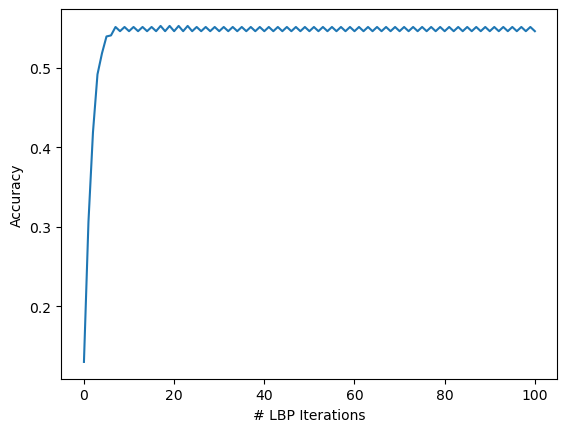

In [4]:
def compute_accuracy(factorgraph):
    score = 0
    for node, state in factorgraph.states.items():
        label = int(data.y[node]) # Ground truth
        pred = np.argmax(state) # Predict using the mode
        if label == pred:
            score += 1

    accuracy = score / len(factorgraph.states)
    return accuracy

# Iterate loopy belief propagation
num_iter = 100
accuracy_list = []
acc = compute_accuracy(f)
accuracy_list.append(acc)
for iter in range(num_iter):
    LoopyBP(f)
    acc = compute_accuracy(f)
    accuracy_list.append(acc)

# Plot accuracy vs. num iterations
plt.plot(accuracy_list)
plt.xlabel('# LBP Iterations')
plt.ylabel('Accuracy')

print(f'Final accuracy: {accuracy_list[-1]*100:>0.1f}%')

We see that LBP leads to a final prediction oscillating around $54.6 \%$ accuracy.

The result is not amazing, but is at least better than chance, which would be $(1/7) \times 100 \approx 14.3 \%$.

## Multilayer Perceptron

Next, we investigate the use of MLP to make predictions on the test set by training only on the node features, ignoring any relational information between nodes in the graph.

In [5]:
# Define simple MLP model
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(1433, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 7)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
        self.X = X
        self.y = y

  def __len__(self):
        return len(self.X)

  def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y


In [6]:
# Split data for training/validation/testing
train_dataset = [data.x[train_nodes], data.y[train_nodes]]
train_dataset = Dataset(*train_dataset)

val_dataset = [data.x[val_nodes], data.y[val_nodes]]
val_dataset = Dataset(*val_dataset)

test_dataset = [data.x[test_nodes], data.y[test_nodes]]
test_dataset = Dataset(*test_dataset)

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Set up MLP model with one hidden layer and train with SGD with L2 regularisation (with `weight_decay=0.02`) to avoid overfitting.

In [7]:
model = MLP()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                 milestones=[20, 30, 50, 100], # List of epoch indices
                                                 gamma=0.5)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return val_loss

In [9]:
epochs = 200
val_loss_curve = []
train_loss_curve = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    train_loss = validate(train_dataloader, model, loss_fn)
    val_loss = validate(val_dataloader, model, loss_fn)
    train_loss_curve.append(train_loss)
    val_loss_curve.append(val_loss)
    scheduler.step()
print("Done!")

Epoch 1
-------------------------------
loss: 1.943475  [    0/  140]
Test Error: 
 Accuracy: 17.9%, Avg loss: 1.938161 

Test Error: 
 Accuracy: 8.8%, Avg loss: 1.951704 

Epoch 2
-------------------------------
loss: 1.950783  [    0/  140]
Test Error: 
 Accuracy: 18.6%, Avg loss: 1.930326 

Test Error: 
 Accuracy: 7.2%, Avg loss: 1.954669 

Epoch 3
-------------------------------
loss: 1.955062  [    0/  140]
Test Error: 
 Accuracy: 20.7%, Avg loss: 1.922567 

Test Error: 
 Accuracy: 7.2%, Avg loss: 1.956290 

Epoch 4
-------------------------------
loss: 1.956775  [    0/  140]
Test Error: 
 Accuracy: 28.6%, Avg loss: 1.914130 

Test Error: 
 Accuracy: 8.0%, Avg loss: 1.956940 

Epoch 5
-------------------------------
loss: 1.956524  [    0/  140]
Test Error: 
 Accuracy: 36.4%, Avg loss: 1.904270 

Test Error: 
 Accuracy: 8.8%, Avg loss: 1.956722 

Epoch 6
-------------------------------
loss: 1.954518  [    0/  140]
Test Error: 
 Accuracy: 41.4%, Avg loss: 1.892109 

Test Error: 


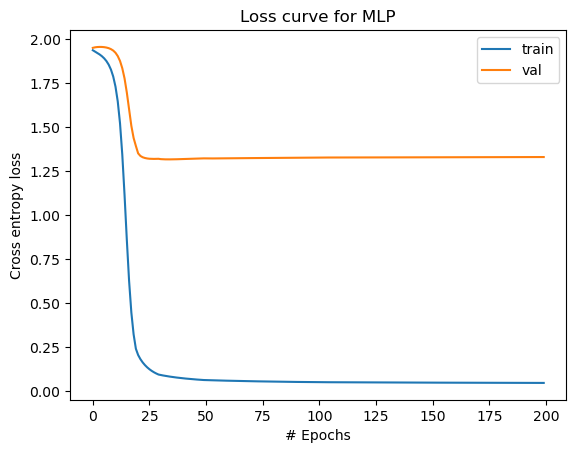

In [10]:
# Plot loss curves
plt.plot(train_loss_curve, label='train')
plt.plot(val_loss_curve, label='val')
plt.xlabel("# Epochs")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for MLP")
plt.legend()

In [11]:
test_loss = validate(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 57.1%, Avg loss: 1.265451 



Again, the result is not great, but is slightly better than our previous result using LBP on a pre-defined Markov random field, demonstrating the power of deep learning.

## Graph Convolutional Network

Finally, we look at the result using GCN, which incorporates both node features (as in MLP) and relational information between nodes on the graph (as in LBP).

In [12]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [13]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

epochs = 200
model.train()
val_loss_curve = []
train_loss_curve = []
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    train_loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    train_loss_curve.append(float(train_loss))
    train_loss.backward()
    optimizer.step()
    
    # Validate
    model.eval()
    val_loss = F.nll_loss(out[data.val_mask], data.y[data.val_mask])
    val_loss_curve.append(float(val_loss))
    pred = model(data).argmax(dim=1)
    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
    acc = int(correct) / int(data.val_mask.sum())
    print(f"Epoch {epoch}: Accuracy: {(100*acc):>0.1f}%, Avg loss: {val_loss:>8f}")


Epoch 0: Accuracy: 36.4%, Avg loss: 1.957369
Epoch 1: Accuracy: 42.8%, Avg loss: 1.908443
Epoch 2: Accuracy: 44.8%, Avg loss: 1.850054
Epoch 3: Accuracy: 49.2%, Avg loss: 1.780481
Epoch 4: Accuracy: 52.8%, Avg loss: 1.710304
Epoch 5: Accuracy: 57.0%, Avg loss: 1.639464
Epoch 6: Accuracy: 61.8%, Avg loss: 1.562640
Epoch 7: Accuracy: 66.4%, Avg loss: 1.480529
Epoch 8: Accuracy: 70.4%, Avg loss: 1.396518
Epoch 9: Accuracy: 73.4%, Avg loss: 1.313609
Epoch 10: Accuracy: 75.0%, Avg loss: 1.234081
Epoch 11: Accuracy: 77.0%, Avg loss: 1.159837
Epoch 12: Accuracy: 77.0%, Avg loss: 1.092184
Epoch 13: Accuracy: 77.4%, Avg loss: 1.031657
Epoch 14: Accuracy: 78.2%, Avg loss: 0.978595
Epoch 15: Accuracy: 78.4%, Avg loss: 0.932951
Epoch 16: Accuracy: 78.2%, Avg loss: 0.894720
Epoch 17: Accuracy: 76.8%, Avg loss: 0.863600
Epoch 18: Accuracy: 76.4%, Avg loss: 0.839052
Epoch 19: Accuracy: 76.4%, Avg loss: 0.820307
Epoch 20: Accuracy: 76.0%, Avg loss: 0.806288
Epoch 21: Accuracy: 75.8%, Avg loss: 0.79580

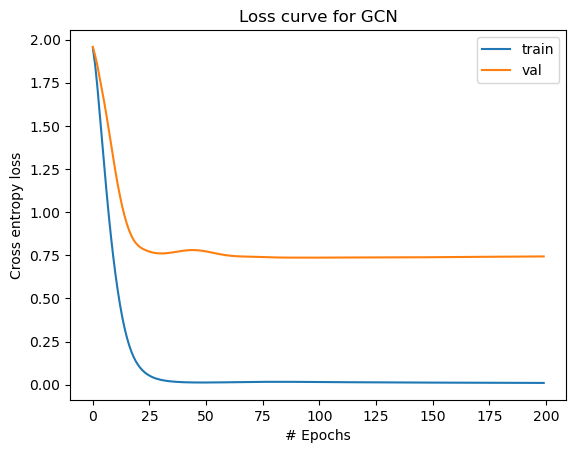

In [14]:
plt.plot(train_loss_curve, label='train')
plt.plot(val_loss_curve, label='val')
plt.xlabel("# Epochs")
plt.ylabel("Cross entropy loss")
plt.title("Loss curve for GCN")
plt.legend()

In [15]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Test accuracy: {acc*100:>0.1f}%')

Test accuracy: 81.1%


The result is much better than the previous two results, highlighting the need to use both node features and graph structure to get good performance on this dataset.